## Reading Data from the STAC API

The Planetary Computer catalogs the datasets we host using the [STAC](http://stacspec.org/) (SpatioTemporal Asset Catalog) specification. We provide a [STAC API](https://github.com/radiantearth/stac-api-spec) endpoint that can be used to search our datasets by space, time, and more. This quickstart will show you how to search for data using our STAC API and open-source Python libraries. For more on how to use our STAC API from R, see [Reading data from the STAC API with R](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac-r/).

First we'll use pystac-client to open up our STAC API:

In [1]:
from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

### Searching

We can use the STAC API to search for assets meeting some criteria. This might include the date and time the asset covers, is spatial extent, or any other property captured in the STAC item's metadata.

In this example we'll search for imagery from [Landsat Collection 2 Level-2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) area around Microsoft's main campus in December of 2020.

In [2]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(collections=["landsat-8-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

/Users/tylere/Documents/GitHub/VorGeo/stac-onboarding/tutorials/stac/mspc_stac/.pixi/envs/default/lib/python3.12/site-packages/pystac_client/item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


4

In that example our spatial query used a bounding box with a `bbox`. Alternatively, you can pass a GeoJSON object as `intersects`

```python
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.2751, 47.5469],
            [-121.9613, 47.9613],
            [-121.9613, 47.9613],
            [-122.2751, 47.9613],
            [-122.2751, 47.5469],
        ]
    ],
}

time_range = "2020-12-01/2020-12-31"

search = catalog.search(
    collections=["landsat-8-c2-l2"], intersects=area_of_interest, datetime=time_range
)
```

`items` is a [`pystac.ItemCollection`](https://pystac.readthedocs.io/en/stable/api/item_collection.html#pystac-item-collection). We can see that 4 items matched our search criteria.

In [3]:
len(items)

4

Each [`pystac.Item`](https://pystac.readthedocs.io/en/stable/api/pystac.html#pystac.Item) in this `ItemCollection` includes all the metadata for that scene. [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) are GeoJSON features, and so can be loaded by libraries like [geopandas](http://geopandas.readthedocs.io/).

In [4]:
import geopandas

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,datetime,platform,proj:bbox,description,instruments,eo:cloud_cover,view:off_nadir,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,view:sun_elevation,landsat:cloud_cover_land,landsat:processing_level,landsat:collection_number,landsat:collection_category,proj:code
0,"POLYGON ((-122.74802 48.51223, -120.22983 48.0...",2020-12-29T18:55:56.738265Z,landsat-8,"[471585.0, 5136885.0, 705015.0, 5373315.0]",Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",100.00,0,027,LC80460272020364LGN00,046,2,162.253231,17.458298,100.00,L2SP,02,T2,EPSG:32610
1,"POLYGON ((-124.29833 48.51325, -121.79248 48.0...",2020-12-20T19:02:09.878796Z,landsat-8,"[353385.0, 5135085.0, 589215.0, 5374215.0]",Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",100.00,0,027,LC80470272020355LGN00,047,2,163.360118,17.414441,100.00,L2SP,02,T2,EPSG:32610
2,"POLYGON ((-122.75189 48.5119, -120.23406 48.09...",2020-12-13T18:56:00.096447Z,landsat-8,"[471285.0, 5136885.0, 704715.0, 5373315.0]",Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",98.73,0,027,LC80460272020348LGN00,046,2,164.126188,17.799744,98.64,L2SP,02,T2,EPSG:32610
3,"POLYGON ((-124.29534 48.51347, -121.78981 48.0...",2020-12-04T19:02:11.194486Z,landsat-8,"[353685.0, 5135085.0, 589515.0, 5374215.0]",Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",1.55,0,027,LC80470272020339LGN00,047,2,164.914060,18.807230,1.90,L2SP,02,T1,EPSG:32610


We can use the `eo` extension to sort the items by cloudiness. We'll grab an item with low cloudiness:

In [5]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
selected_item

<Item id=LC08_L2SP_047027_20201204_02_T1>

Each STAC item has one or more [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object), which include links to the actual files.

In [6]:
import rich.table

table = rich.table.Table("Asset Key", "Descripiption")
for asset_key, asset in selected_item.assets.items():
    # print(f"{asset_key:<25} - {asset.title}")
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key                 ┃ Descripiption                                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ANG                       │ Angle Coefficients File                        │
│ SR_B1                     │ Coastal/Aerosol Band (B1)                      │
│ SR_B2                     │ Blue Band (B2)                                 │
│ SR_B3                     │ Green Band (B3)                                │
│ SR_B4                     │ Red Band (B4)                                  │
│ SR_B5                     │ Near Infrared Band 0.8 (B5)                    │
│ SR_B6                     │ Short-wave Infrared Band 1.6 (B6)              │
│ SR_B7                     │ Short-wave Infrared Band 2.2 (B7)              │
│ ST_QA                     │ Surface Temperature Quality Assessment Band    │
│ ST_B10                    │ Surface Temperature Band (B10)                 │
│ MTL.txt                   │ Product Metadata File                          │
│ MTL.xml                   │ Product Metadata File (xml)                    │
│ ST_DRAD                   │ Downwelled Radiance Band                       │
│ ST_EMIS                   │ Emissivity Band                                │
│ ST_EMSD                   │ Emissivity Standard Deviation Band             │
│ ST_TRAD                   │ Thermal Radiance Band                          │
│ ST_URAD                   │ Upwelled Radiance Band                         │
│ MTL.json                  │ Product Metadata File (json)                   │
│ QA_PIXEL                  │ Pixel Quality Assessment Band                  │
│ ST_ATRAN                  │ Atmospheric Transmittance Band                 │
│ ST_CDIST                  │ Cloud Distance Band                            │
│ QA_RADSAT                 │ Radiometric Saturation Quality Assessment Band │
│ thumbnail                 │ Thumbnail image                                │
│ SR_QA_AEROSOL             │ Aerosol Quality Analysis Band                  │
│ reduced_resolution_browse │ Reduced resolution browse image                │
└───────────────────────────┴────────────────────────────────────────────────┘

Here, we'll inspect the `thumbnail` asset.

In [7]:
selected_item.assets["thumbnail"].to_dict()

{'href': 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20210313_02_T1/LC08_L2SP_047027_20201204_20210313_02_T1_thumb_small.jpeg',
 'type': 'image/jpeg',
 'title': 'Thumbnail image'}

In [8]:
from IPython.display import Image

Image(url=selected_item.assets["thumbnail"].href, width=500)

That `rendered_preview` asset is generated dynamically from the raw data using the Planetary Computer's [data API](http://planetarycomputer.microsoft.com/api/data/v1/). We can access the raw data, stored as Cloud Optimzied GeoTIFFs in Azure Blob Storage, using one of the other assets. That said, we do need to do one more thing before accessing the data. If we simply made a request to the file in blob storage we'd get a 404:

In [9]:
import requests

url = selected_item.assets["SR_B2"].href
print("Accessing", url)
response = requests.get(url)
response

Accessing https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20210313_02_T1/LC08_L2SP_047027_20201204_20210313_02_T1_SR_B2.TIF


<Response [404]>

That's because the Plantary Computer uses Azure Blob Storage [SAS Tokens](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview#how-a-shared-access-signature-works) to enable access to our data, which allows us to provide the data for free to anyone, anywhere while maintaining some control over the amount of egress for datasets.

To get a token for access, you can use the Planetary Computer's [Data Authentication API](). You can access that anonymously, or you can provide an API Key for higher rate limits and longer-lived tokens.

You can also use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to generate tokens and sign asset HREFs for access. You can install via pip with

```
> pip install planetary-computer
```

In [10]:
import planetary_computer

# PC_SDK_SUBSCRIPTION_KEY
signed_href = planetary_computer.sign(selected_item).assets["SR_B2"].href

We can load up that single COG using libraries like [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) or [rasterio](https://rasterio.readthedocs.io/en/latest/)

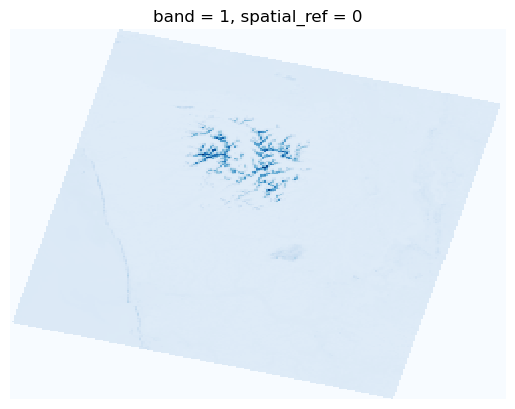

In [11]:
# import xarray as xr
import rioxarray

ds = rioxarray.open_rasterio(signed_href, overview_level=4).squeeze()
img = ds.plot(cmap="Blues", add_colorbar=False)
img.axes.set_axis_off();

If you wish to work with multiple STAC items as a datacube, you can use libraries like [stackstac](https://stackstac.readthedocs.io/) or [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html).

In [12]:
import stackstac

ds = stackstac.stack(
  planetary_computer.sign(items),
  epsg=4326
)
ds

<xarray.DataArray 'stackstac-5f25f07c26b5084e490c1bc0470c1b41' (time: 4,
                                                                band: 19,
                                                                y: 7973,
                                                                x: 11724)> Size: 57GB
dask.array<fetch_raster_window, shape=(4, 19, 7973, 11724), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 32B 2020-12-04T19:02:1...
    id                           (time) <U31 496B 'LC08_L2SP_047027_20201204_...
  * band                         (band) <U13 988B 'SR_B1' ... 'SR_QA_AEROSOL'
  * x                            (x) float64 94kB -125.0 -125.0 ... -120.2
  * y                            (y) float64 64kB 48.51 48.51 ... 46.35 46.35
    landsat:scene_id             (time) <U21 336B 'LC80470272020339LGN00' ......
    ...                           ...
    gsd                          (band) float64 152B 30.0 30.0 ... 30.0 30.0
    title                        (band) <U46 3kB 'Coastal/Aerosol Band (B1)' ...
    common_name                  (band) object 152B 'coastal' 'blue' ... None
    center_wavelength            (band) object 152B 0.44 0.48 0.56 ... None None
    full_width_half_max          (band) object 152B 0.02 0.06 0.06 ... None None
    epsg                         int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-124.98521687521375, 46.353...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-124.99|\n| 0.00,-0.00, 48.51|\n| 0.00, 0.00...
    resolution_xy:  (0.0004059912453880883, 0.0002711252980397484)

### Searching on additional properties

Previously, we searched for items by space and time. Because the Planetary Computer's STAC API supports the [query](https://github.com/radiantearth/stac-api-spec/blob/master/fragments/query/README.md) parameter, you can search on additional properties on the STAC item.

For example, collections like `sentinel-2-l2a` and `landsat-8-c2-l2` both implement the [`eo` STAC extension](https://github.com/stac-extensions/eo) and include an `eo:cloud_cover` property. Use `query={"eo:cloud_cover": {"lt": 20}}` to return only items that are less than 20% cloudy.

In [13]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
)
items = search.get_all_items()

/Users/tylere/Documents/GitHub/VorGeo/stac-onboarding/tutorials/stac/mspc_stac/.pixi/envs/default/lib/python3.12/site-packages/pystac_client/item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Other common uses of the `query` parameter is to filter a collection down to items of a specific type, For example, the [GOES-CMI](https://planetarycomputer.microsoft.com/dataset/goes-cmi) collection includes images from various when the satellite is in various modes, which produces images of either the Full Disk of the earth, the continental United States, or a mesoscale. You can use `goes:image-type` to filter down to just the ones you want.

In [14]:
search = catalog.search(
    collections=["goes-cmi"],
    bbox=[-67.2729, 25.6000, -61.7999, 27.5423],
    datetime=["2018-09-11T13:00:00Z", "2018-09-11T15:40:00Z"],
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)

### Analyzing STAC Metadata

STAC items are proper GeoJSON Features, and so can be treated as a kind of data on their own.

In [15]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -110.9613, 47.7458],
    datetime="2020-12-26/2020-12-31",
)
items = search.get_all_items()

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].explore(
    column="eo:cloud_cover", style_kwds={"fillOpacity": 0.1}
)

Or we can plot cloudiness of a region over time.

In [16]:
import pandas as pd

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -123.9613, 45.7458],
    datetime="2020-01-01/2020-12-31",
)
items = search.get_all_items()
df = geopandas.GeoDataFrame.from_features(items.to_dict())
df["datetime"] = pd.to_datetime(df["datetime"])

/Users/tylere/Documents/GitHub/VorGeo/stac-onboarding/tutorials/stac/mspc_stac/.pixi/envs/default/lib/python3.12/site-packages/pystac_client/item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


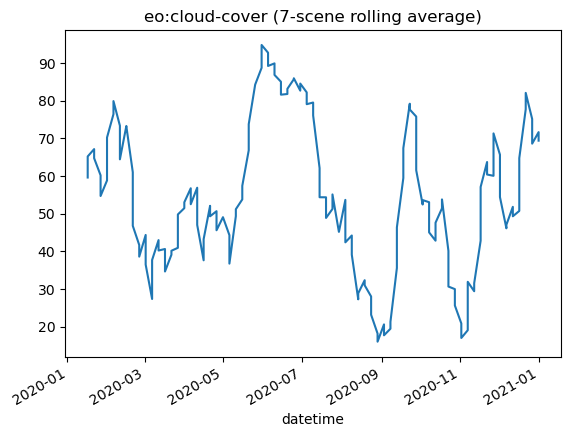

In [17]:
ts = df.set_index("datetime").sort_index()["eo:cloud_cover"].rolling(7).mean()
ts.plot(title="eo:cloud-cover (7-scene rolling average)");

### Working with STAC Catalogs and Collections

Our `catalog` is a [STAC Catalog](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) that we can crawl or search. The Catalog contains [STAC Collections](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) for each dataset we have indexed (which is not the yet the entirity of data hosted by the Planetary Computer).

Collections have information about the [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) they contain. For instance, here we look at the [Bands](https://github.com/stac-extensions/eo#band-object) available for [Landsat Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data:

In [18]:
import pandas as pd

landsat = catalog.get_collection("landsat-c2-l2")

bands = [k for k,v in landsat.extra_fields['item_assets'].items() if 'data' in v['roles']]
pd.DataFrame(bands)

,0
0,qa
1,red
2,blue
3,drad
4,emis
5,emsd
6,lwir
7,trad
8,urad
9,atran


We can see what [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) are available on our item with:

In [19]:
pd.DataFrame.from_dict(landsat.extra_fields["item_assets"], orient="index")[
    ["title", "description", "gsd"]
]

,title,description,gsd
qa,Surface Temperature Quality Assessment Band,Collection 2 Level-2 Quality Assessment Band (...,NaN
ang,Angle Coefficients File,Collection 2 Level-1 Angle Coefficients File,NaN
red,Red Band,NaN,NaN
blue,Blue Band,NaN,NaN
drad,Downwelled Radiance Band,Collection 2 Level-2 Downwelled Radiance Band ...,NaN
emis,Emissivity Band,Collection 2 Level-2 Emissivity Band (ST_EMIS)...,NaN
emsd,Emissivity Standard Deviation Band,Collection 2 Level-2 Emissivity Standard Devia...,NaN
lwir,Surface Temperature Band,Collection 2 Level-2 Thermal Infrared Band (ST...,NaN
trad,Thermal Radiance Band,Collection 2 Level-2 Thermal Radiance Band (ST...,NaN
urad,Upwelled Radiance Band,Collection 2 Level-2 Upwelled Radiance Band (S...,NaN


Some collections, like [Daymet](https://planetarycomputer.microsoft.com/dataset/daymet-daily-na) include collection-level assets. You can use the `.assets` property to access those assets.

In [20]:
collection = catalog.get_collection("daymet-daily-na")
collection

<CollectionClient id=daymet-daily-na>

Just like assets on items, these assets include links to data in Azure Blob Storage.

In [21]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://daymeteuwest.blob.core.windows.net/daymet-zarr/daily/na.zarr>

In [22]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

TypeError: Unsupported type for store_like: 'FSMap'